<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW_lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###***Step one, set up the environment*** ###

In [1]:
# Install stable versions to avoid numpy-related bugs
!pip install --quiet numpy==1.23.5 scikit-learn==1.2.2 gensim==4.3.0

In [2]:
# Import libraries
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [3]:
# Load pre-trained GloVe embeddings (100-dimensional)
embedding_model = api.load("glove-wiki-gigaword-100")

# Helper function to fetch vector
def get_vector(word):
    return embedding_model[word] if word in embedding_model else None

# Helper function to fetch multiple vectors
def get_vectors(words):
    return np.array([get_vector(word) for word in words if get_vector(word) is not None])


[==================================================] 100.0% 128.1/128.1MB downloaded


##**Define semantic words classes**

In [4]:
# Define 10 semantic classes, each with 5 word pairs
semantic_classes = {
    "gender": [
        ("king", "queen"),
        ("man", "woman"),
        ("boy", "girl"),
        ("husband", "wife"),
        ("actor", "actress")
    ],
    "past_tense": [
        ("run", "ran"),
        ("go", "went"),
        ("write", "wrote"),
        ("eat", "ate"),
        ("speak", "spoke")
    ],
    "plural": [
        ("dog", "dogs"),
        ("car", "cars"),
        ("child", "children"),
        ("mouse", "mice"),
        ("foot", "feet")
    ],
    "comparative": [
        ("fast", "faster"),
        ("small", "smaller"),
        ("happy", "happier"),
        ("strong", "stronger"),
        ("bright", "brighter")
    ],
    "superlative": [
        ("fast", "fastest"),
        ("small", "smallest"),
        ("happy", "happiest"),
        ("strong", "strongest"),
        ("bright", "brightest")
    ],
    "country_capital": [
        ("france", "paris"),
        ("italy", "rome"),
        ("germany", "berlin"),
        ("japan", "tokyo"),
        ("egypt", "cairo")
    ],
    "currency": [
        ("usa", "dollar"),
        ("japan", "yen"),
        ("uk", "pound"),
        ("france", "euro"),
        ("china", "yuan")
    ],
    "tool_user": [
        ("pen", "writer"),
        ("hammer", "carpenter"),
        ("brush", "painter"),
        ("scalpel", "surgeon"),
        ("camera", "photographer")
    ],
    "job_object": [
        ("chef", "pan"),
        ("driver", "car"),
        ("farmer", "tractor"),
        ("pianist", "piano"),
        ("teacher", "book")
    ],
    "animal_sound": [
        ("dog", "bark"),
        ("cat", "meow"),
        ("cow", "moo"),
        ("duck", "quack"),
        ("lion", "roar")
    ]
}


In [5]:
### Now we gather all unique words and their vectors:
# Flatten to get all unique words
all_words = set()
for pairs in semantic_classes.values():
    for w1, w2 in pairs:
        all_words.add(w1)
        all_words.add(w2)

# Get vectors only for words present in embedding model
word_vectors = {word: get_vector(word) for word in all_words if get_vector(word) is not None}

# Final word list (with embeddings)
words_with_vectors = list(word_vectors.keys())
print(f"Total unique words with embeddings: {len(words_with_vectors)}")


Total unique words with embeddings: 91


##**Now we will do PCA analysis to visualise wodr embeddings in a 2D space**##

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


In [18]:
def plot_words_2d(word_list, vectors, title):
    pca = PCA(n_components=2)
    X = np.array([vectors[word] for word in word_list])
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(16, 12))
    #plt.xlim(-4.1, 7.0)
    #plt.ylim(-3.5, 3.5)
    for i, word in enumerate(word_list):
        plt.scatter(X_pca[i, 0], X_pca[i, 1])
        plt.text(X_pca[i, 0] + 0.02, X_pca[i, 1] + 0.02, word, fontsize=9)
    plt.title(title)
    plt.grid(True)
    plt.show()


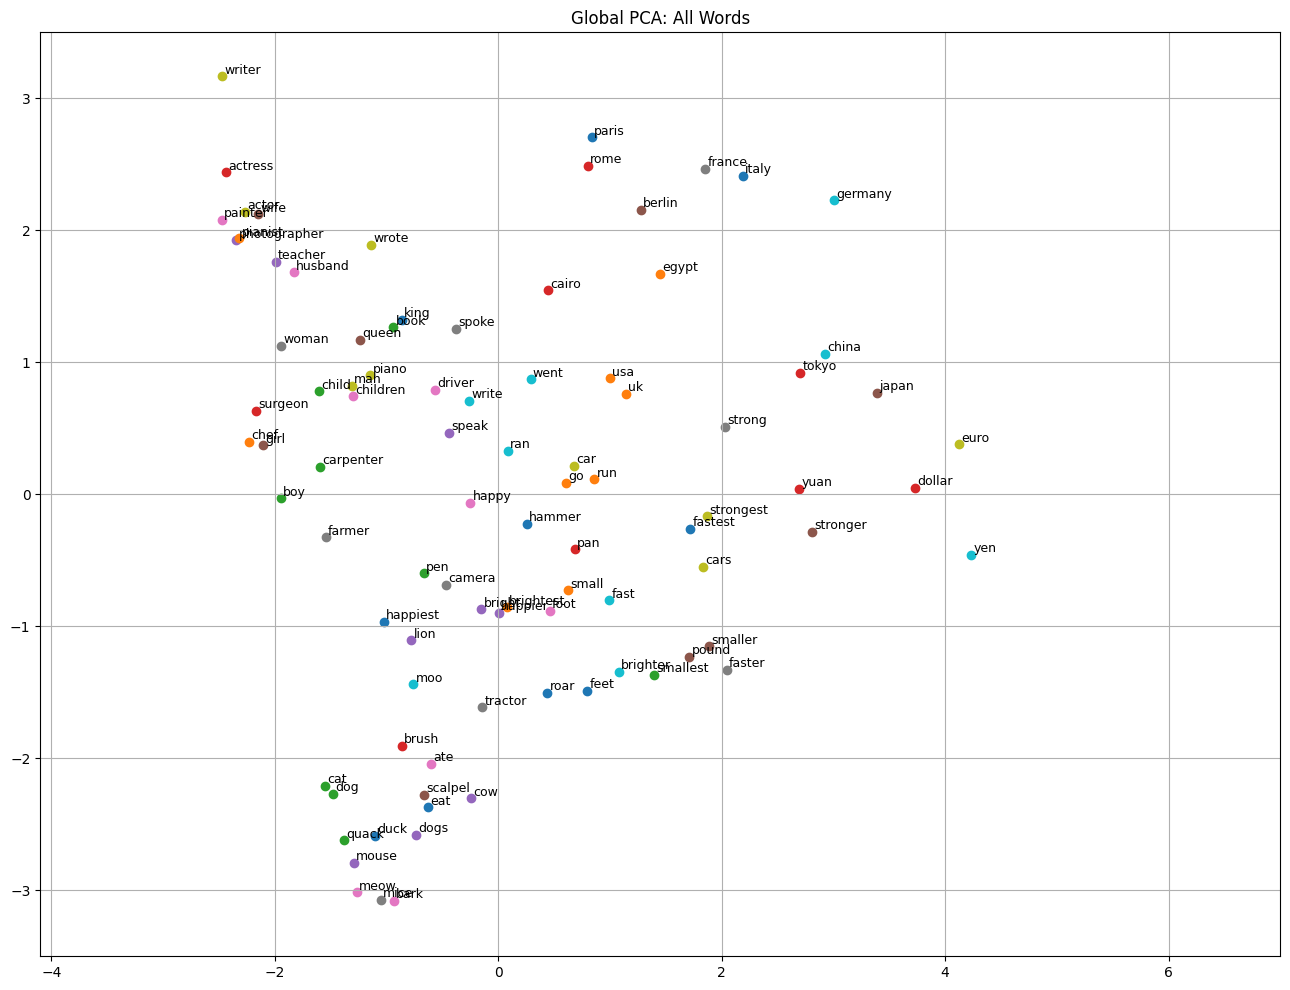

In [15]:
#Global PCA
plot_words_2d(words_with_vectors, word_vectors, "Global PCA: All Words")

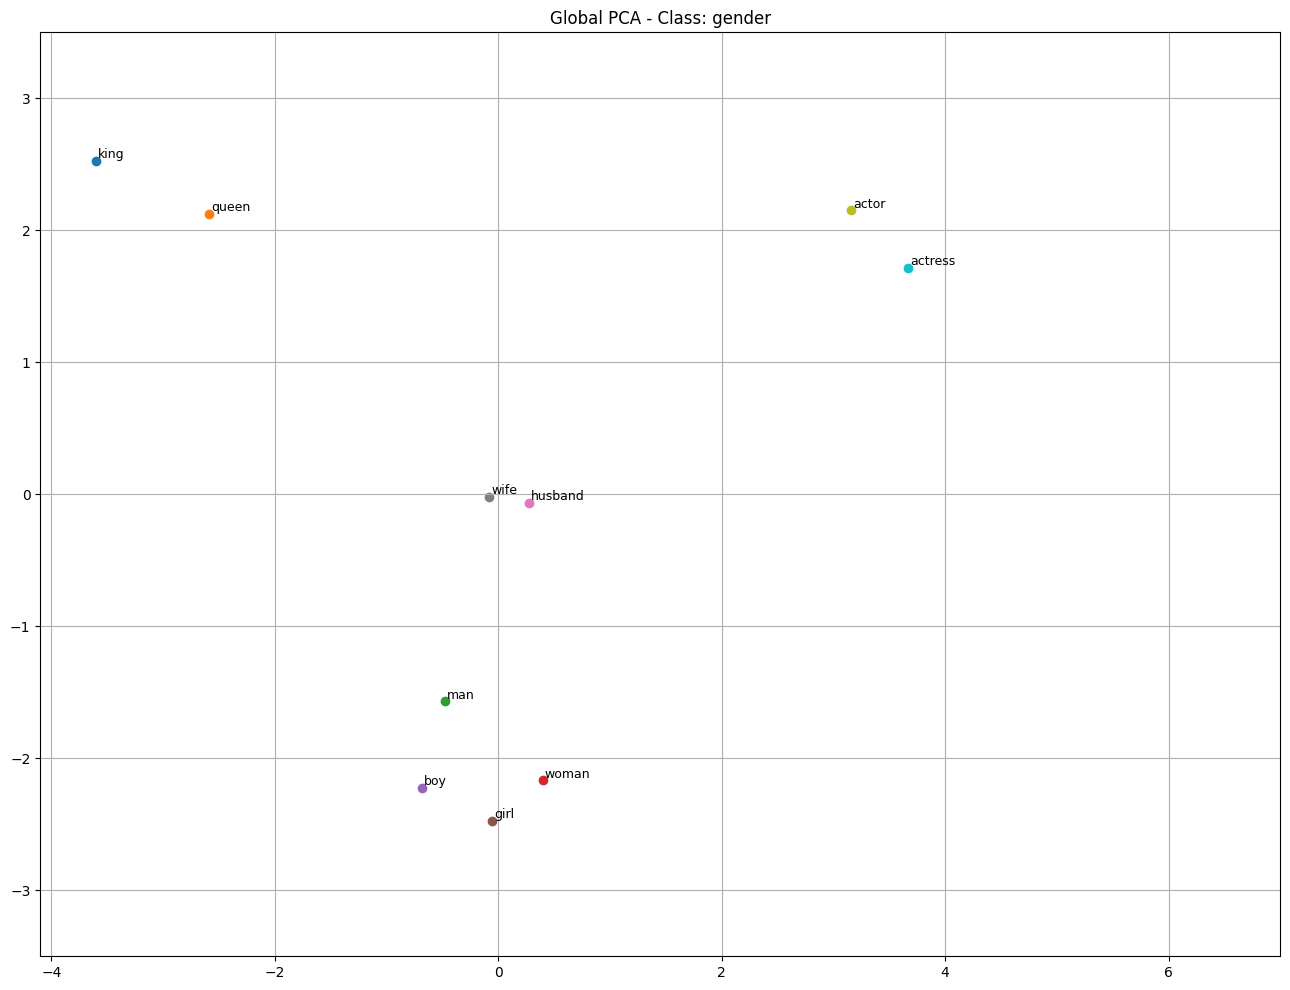

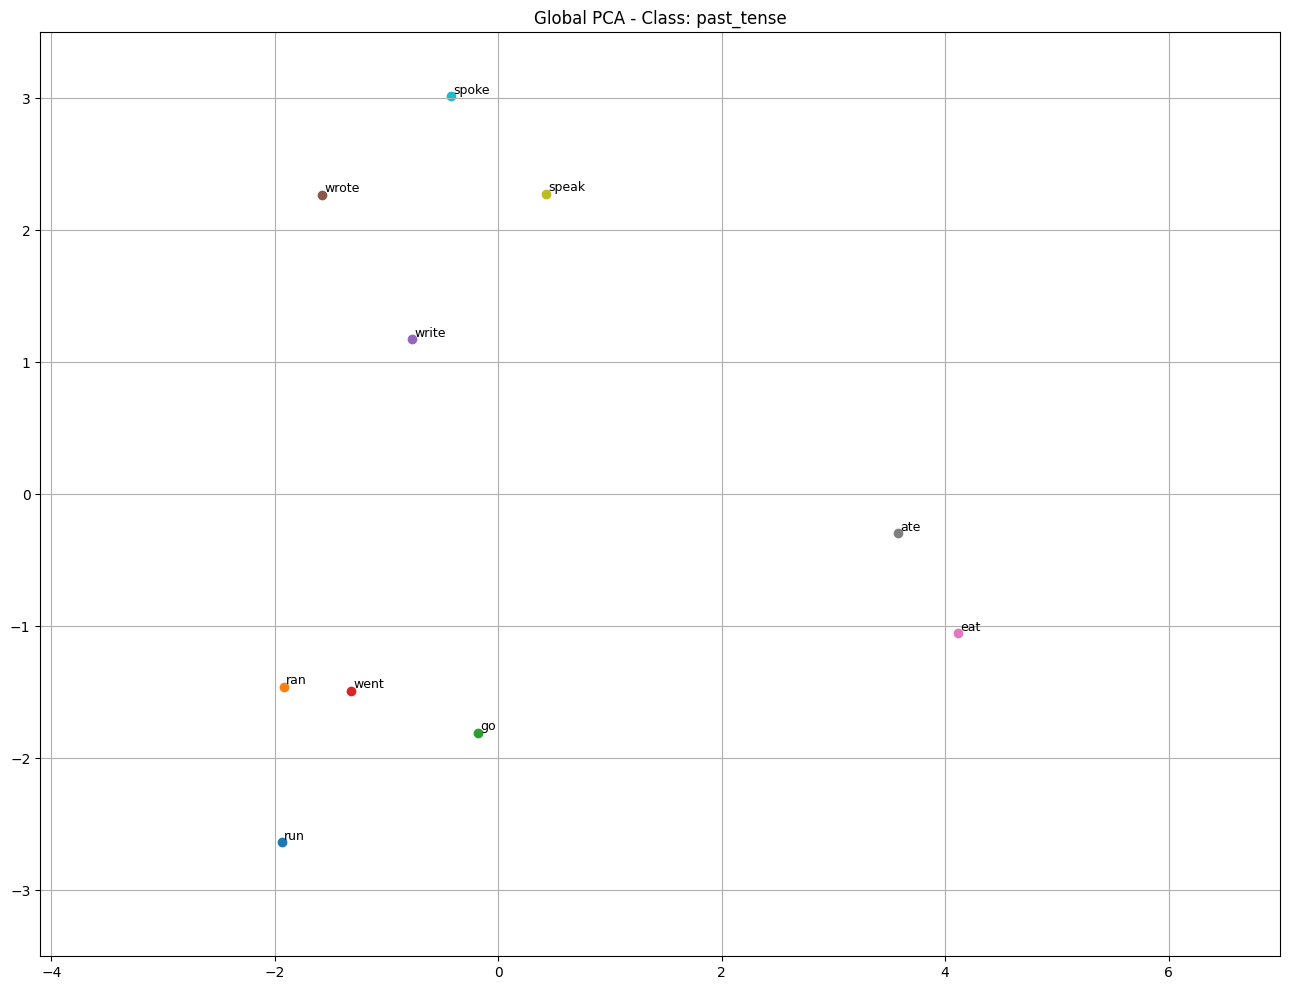

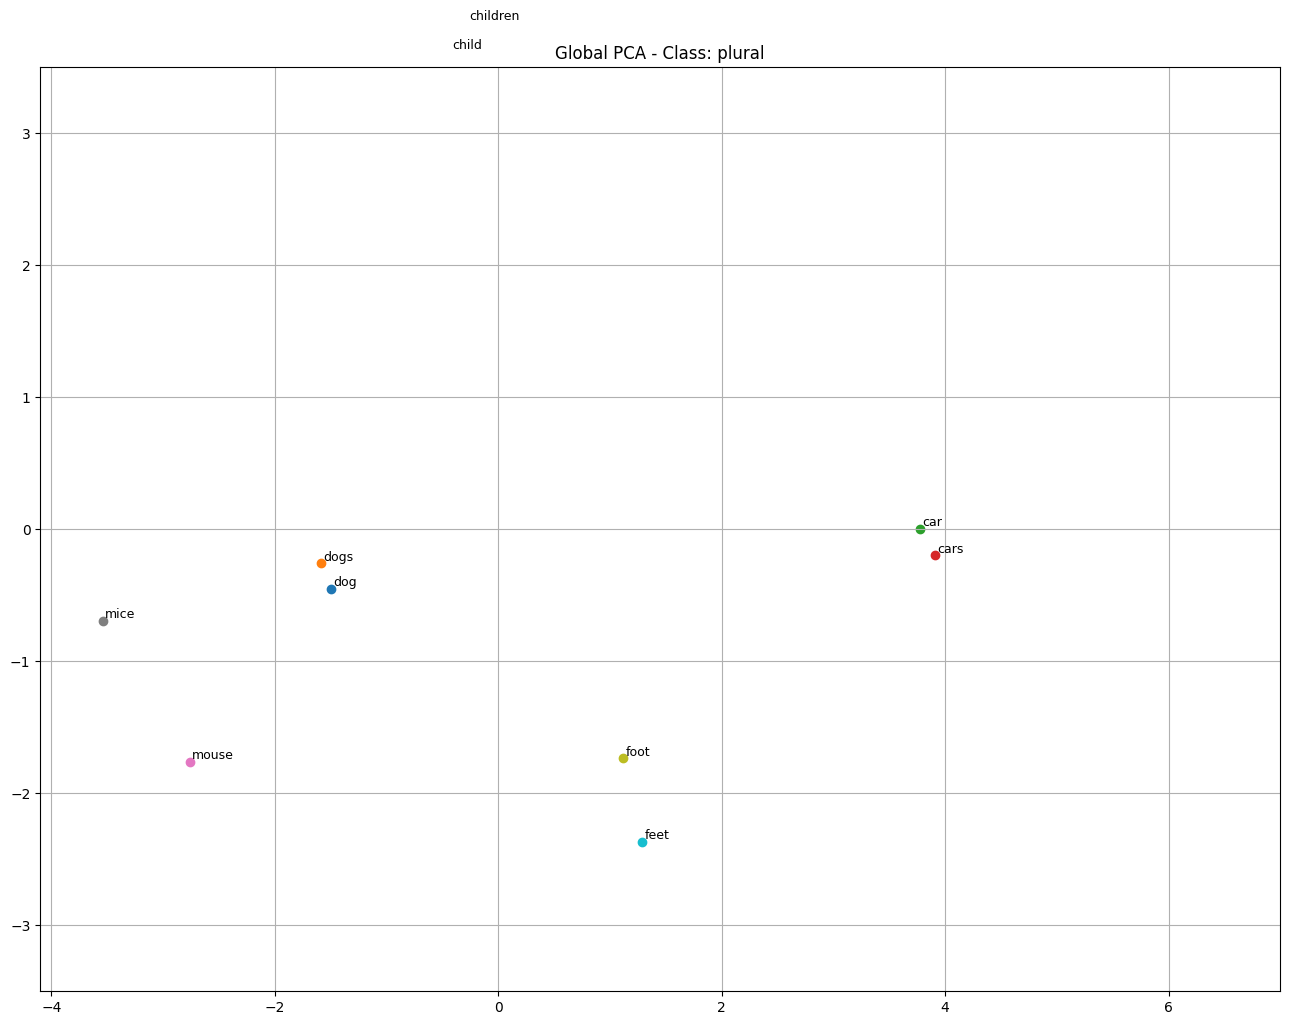

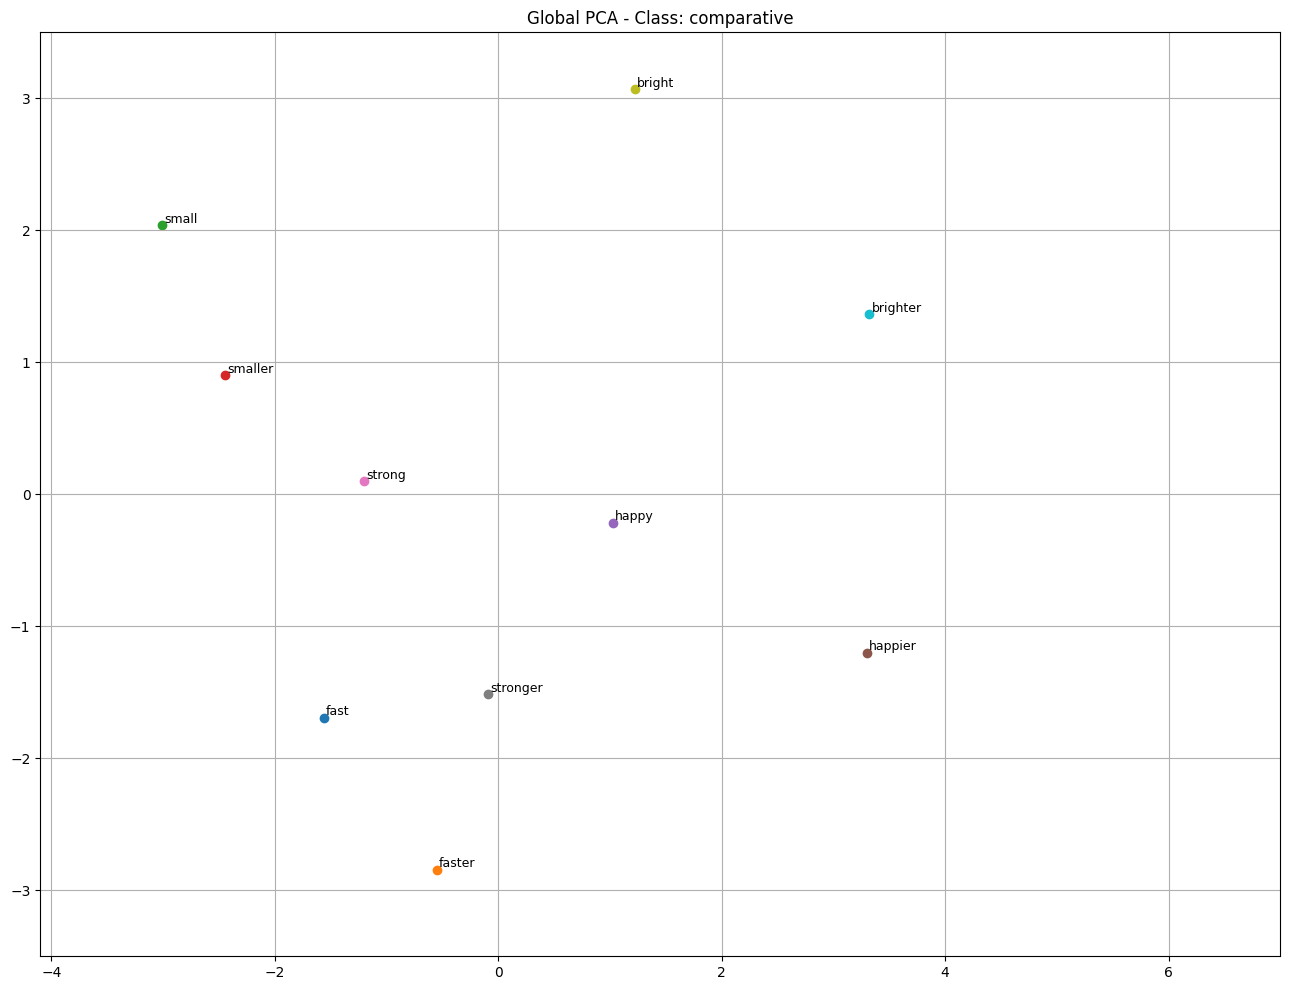

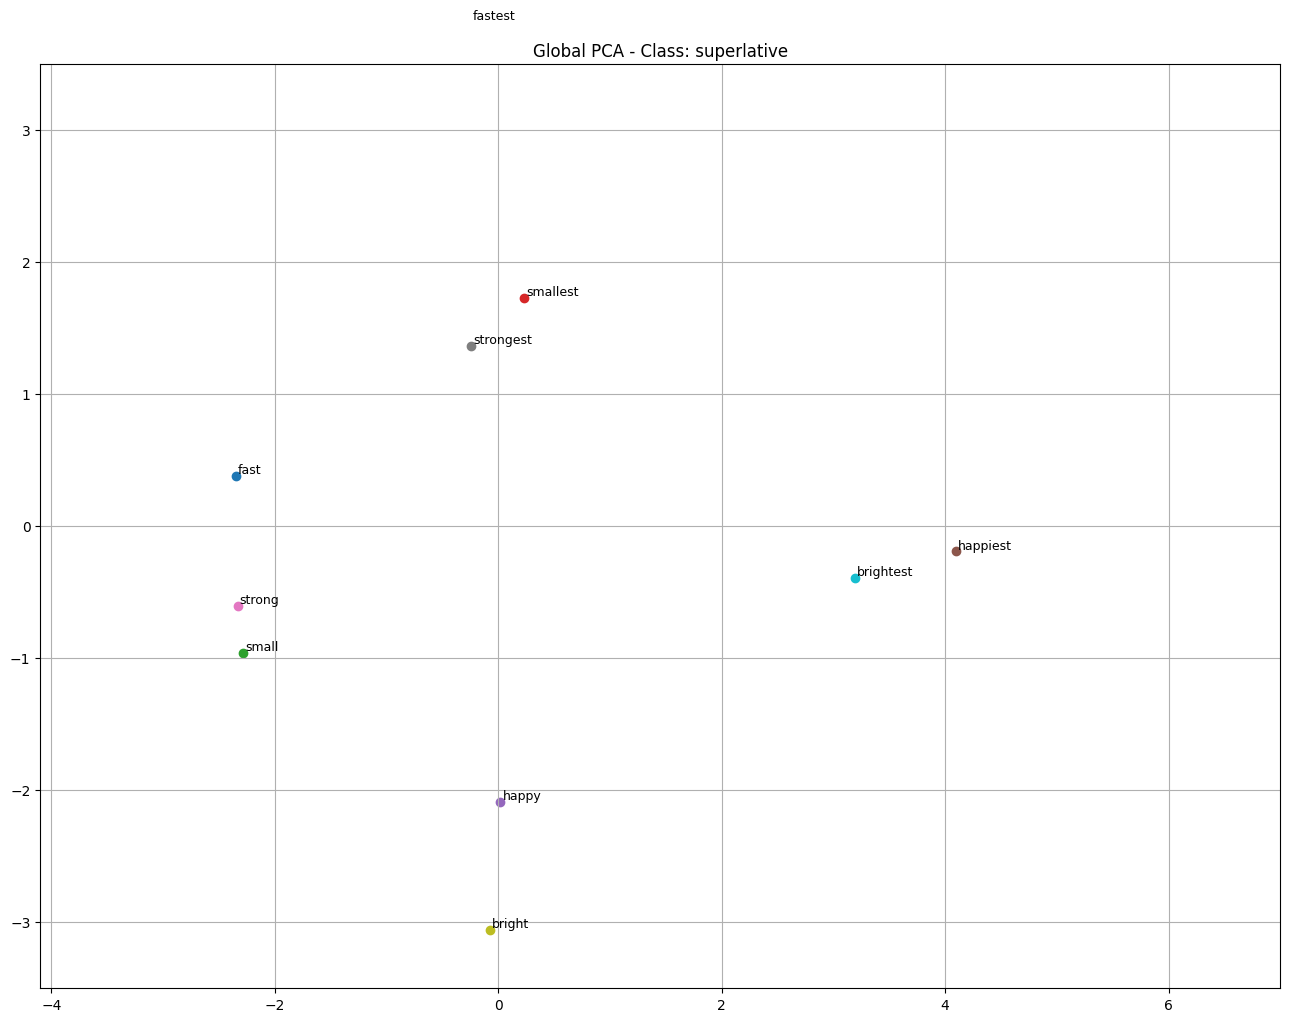

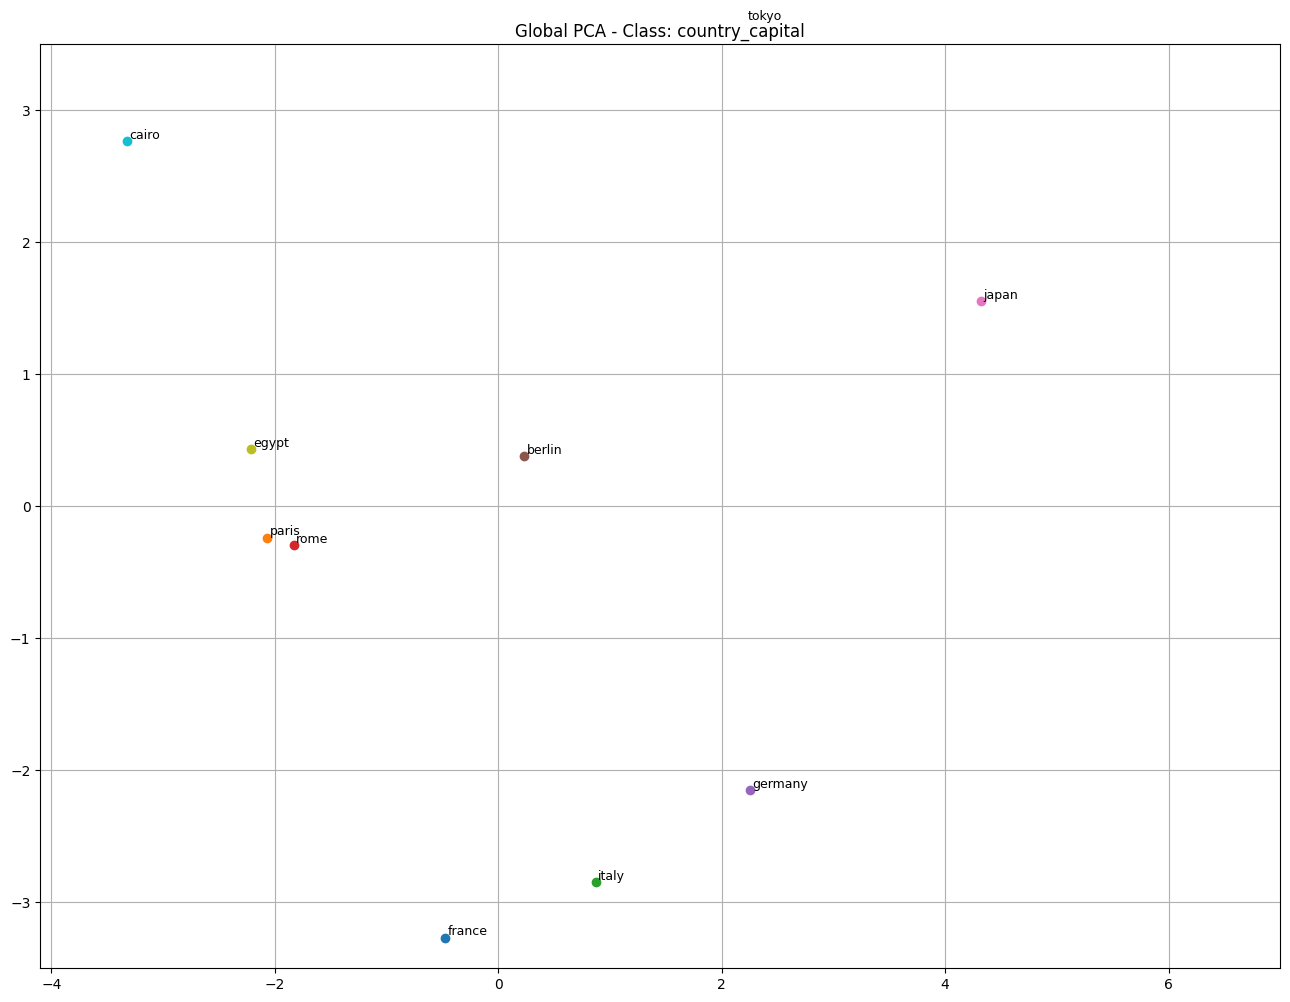

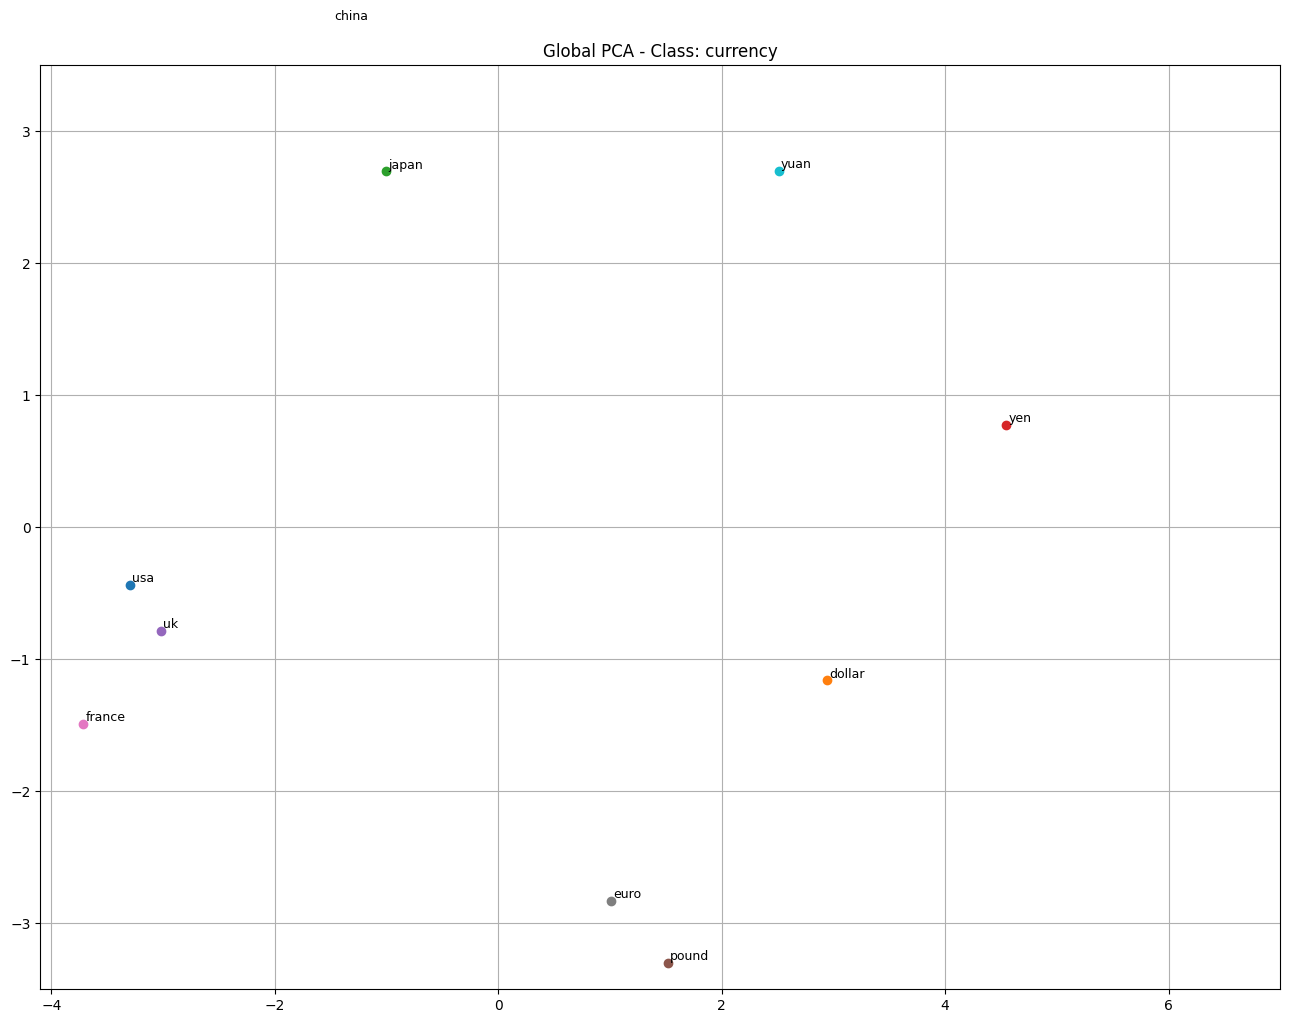

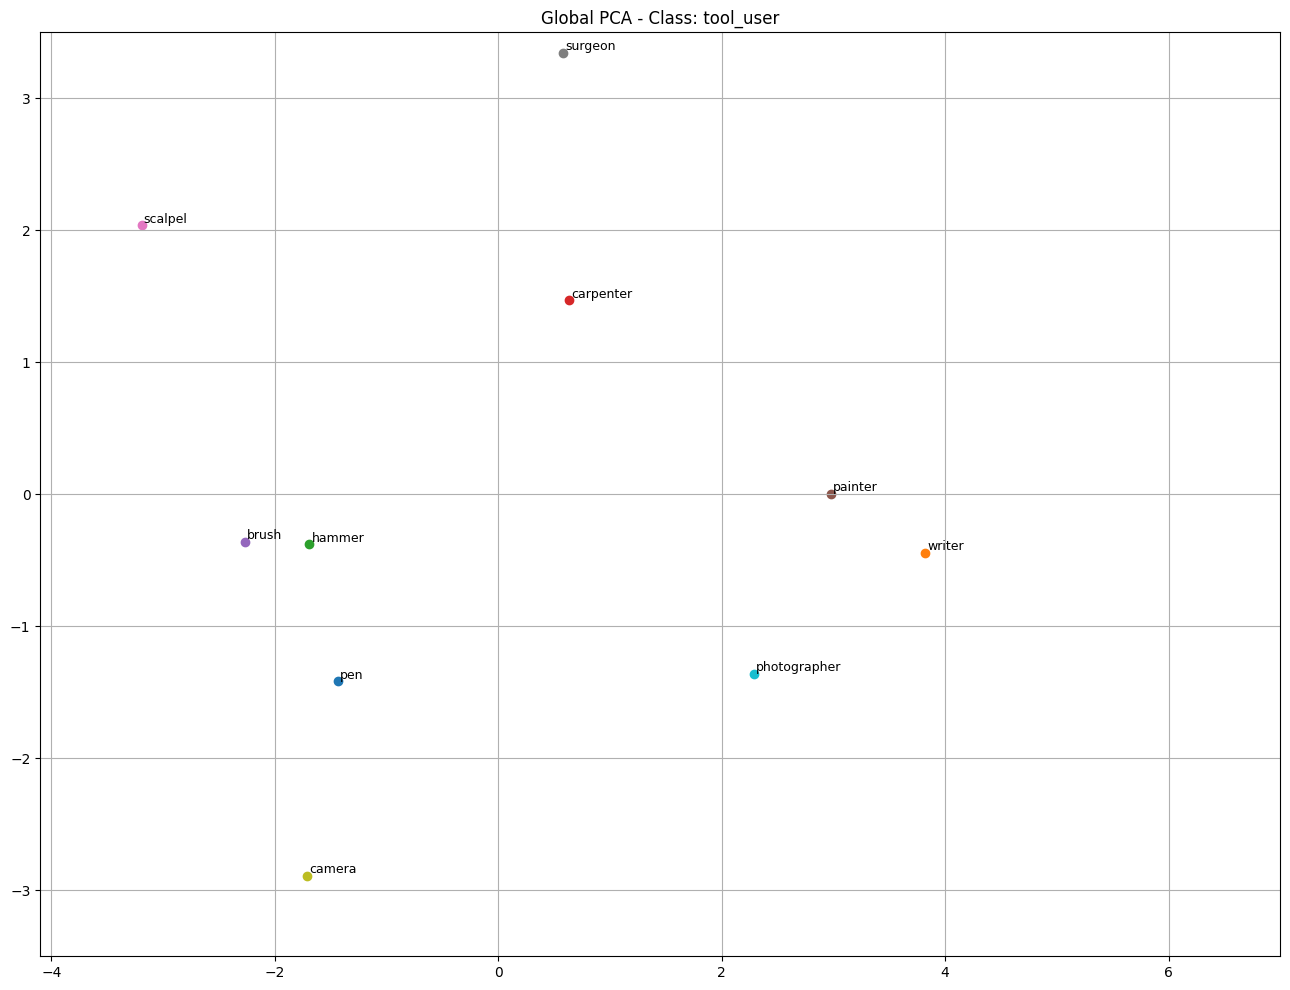

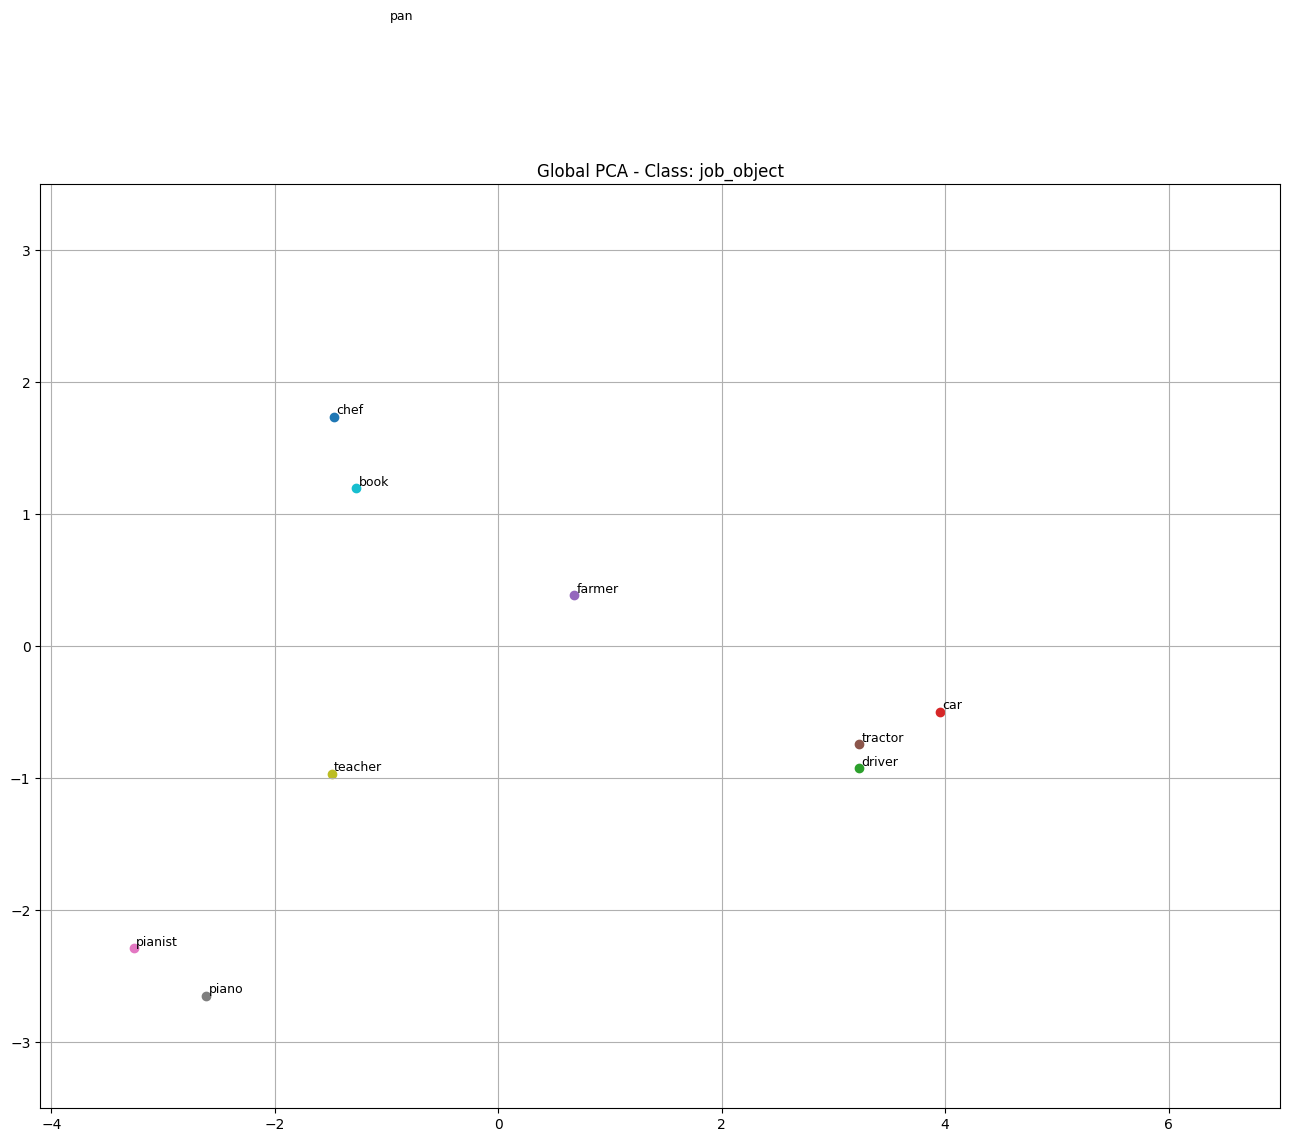

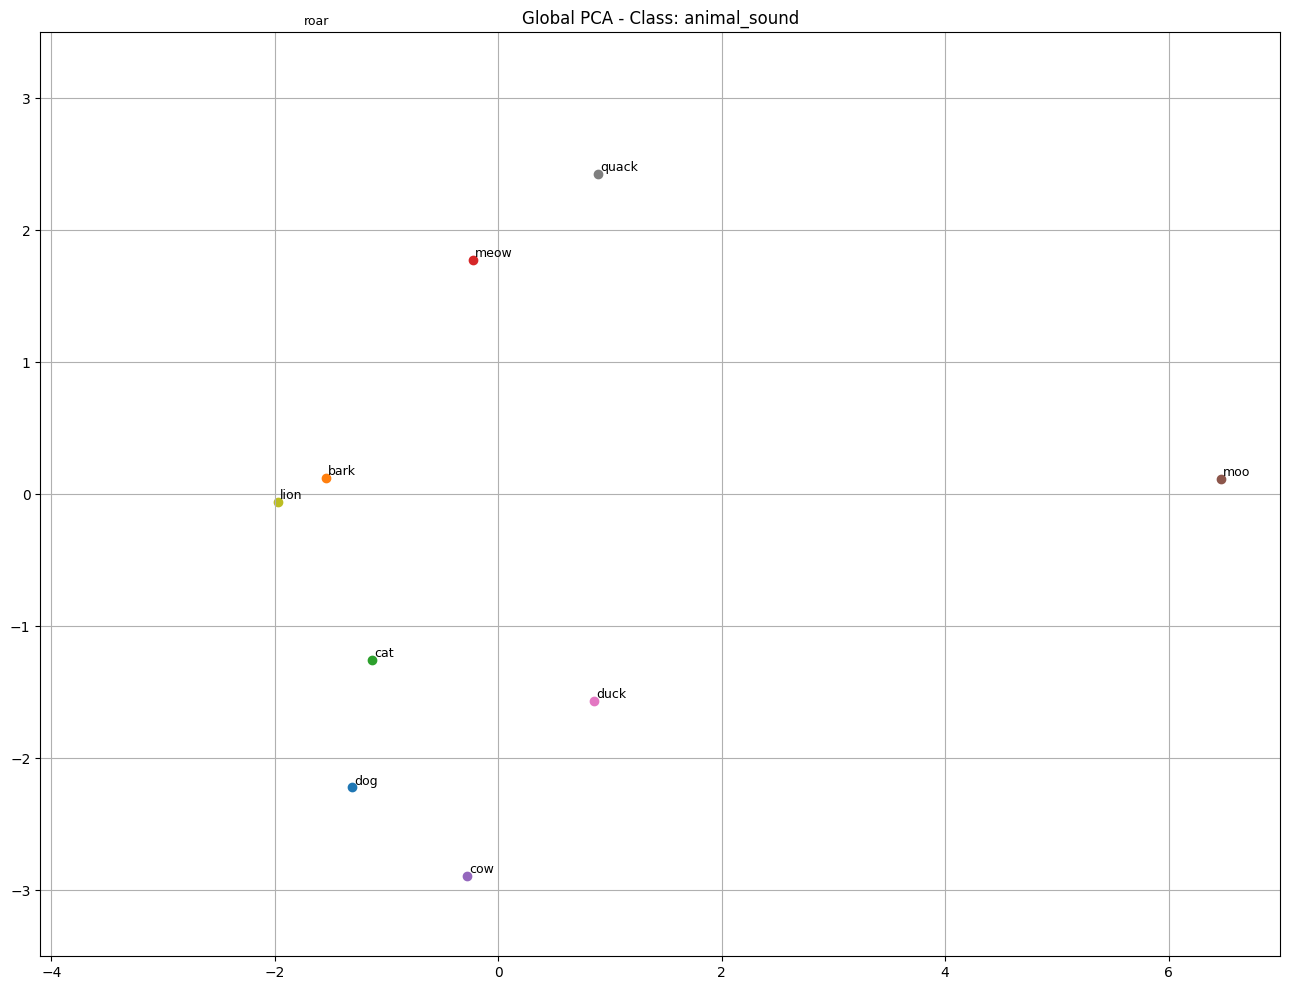

In [16]:
#Global PCA, but one class at a time &&& in a global space:
for class_name, pairs in semantic_classes.items():
    class_words = [w for pair in pairs for w in pair if w in word_vectors]
    plot_words_2d(class_words, word_vectors, f"Global PCA - Class: {class_name}")


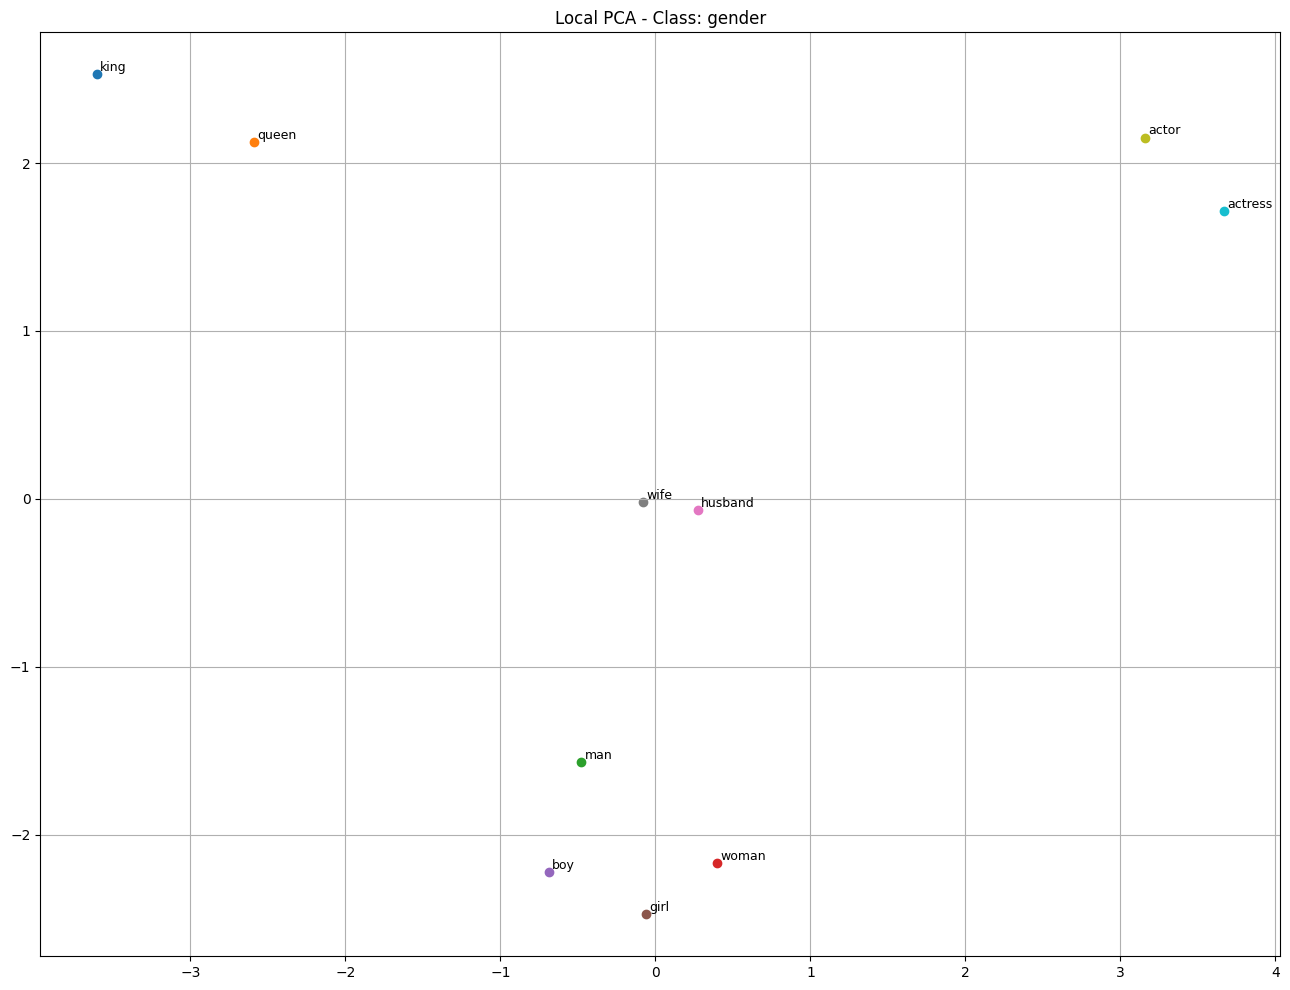

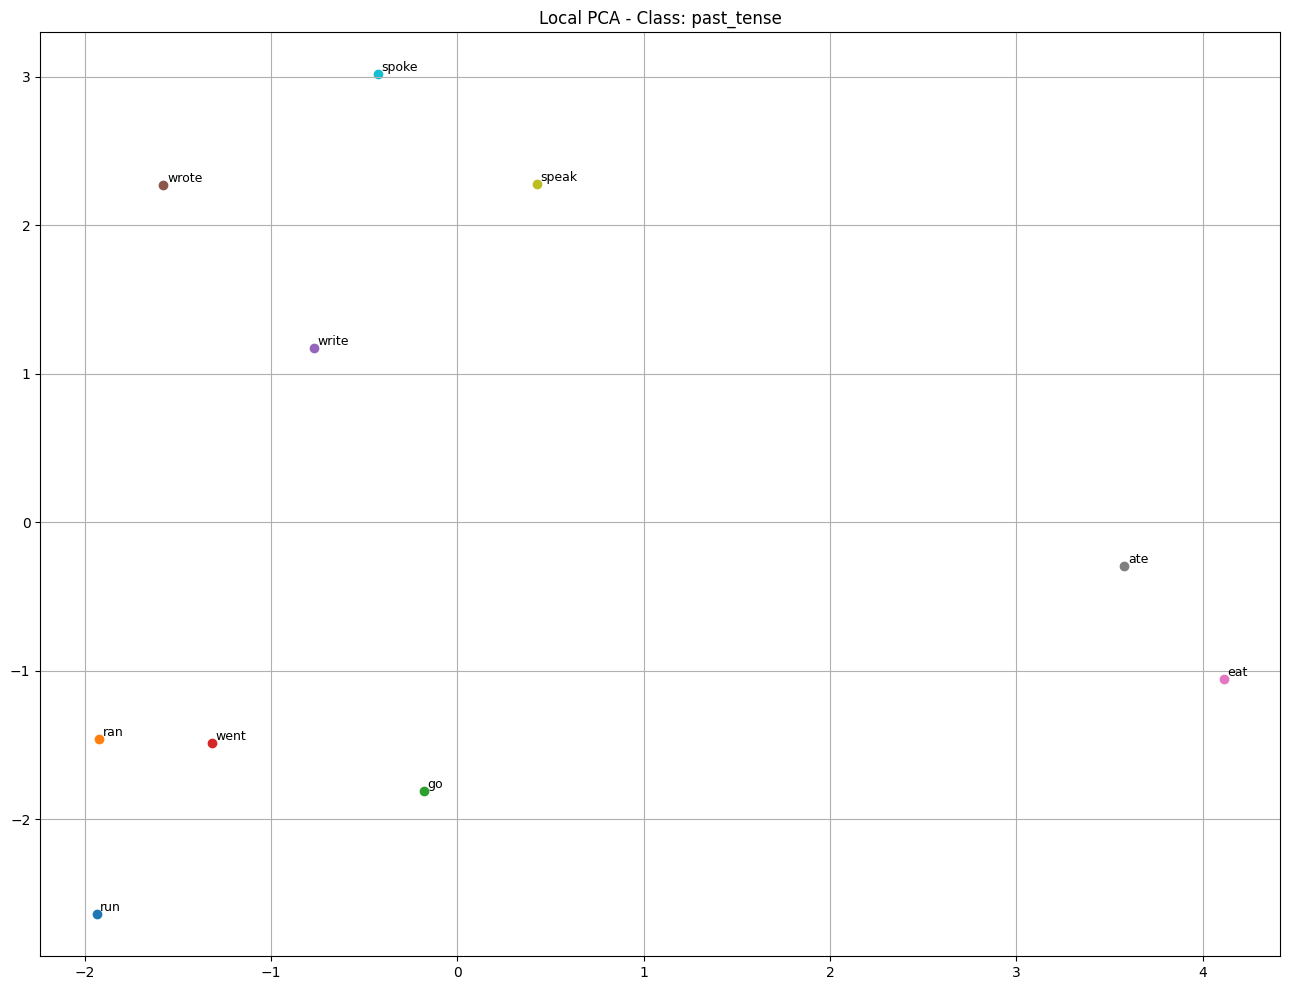

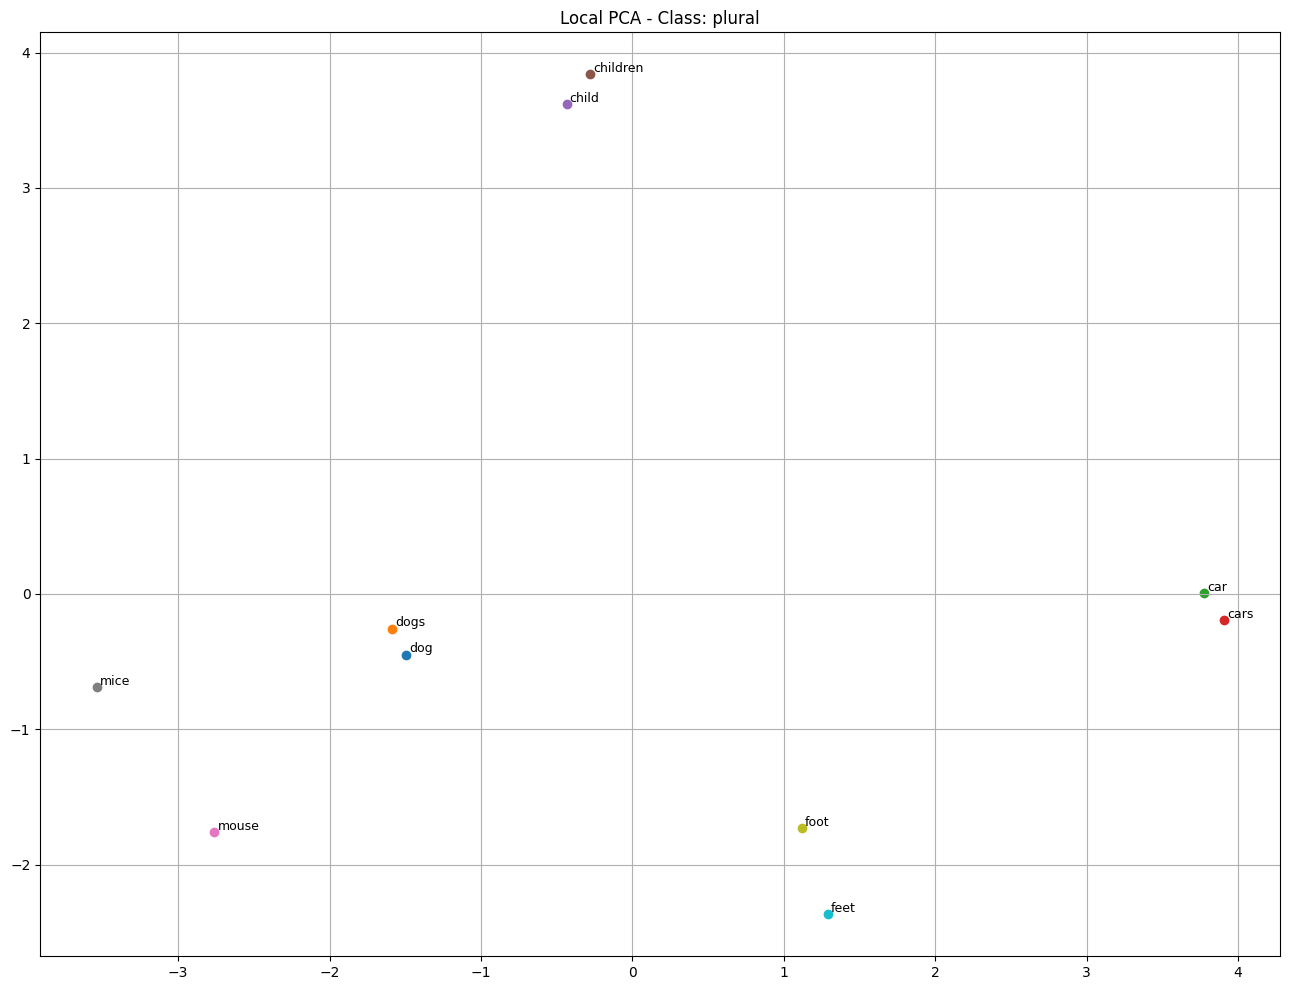

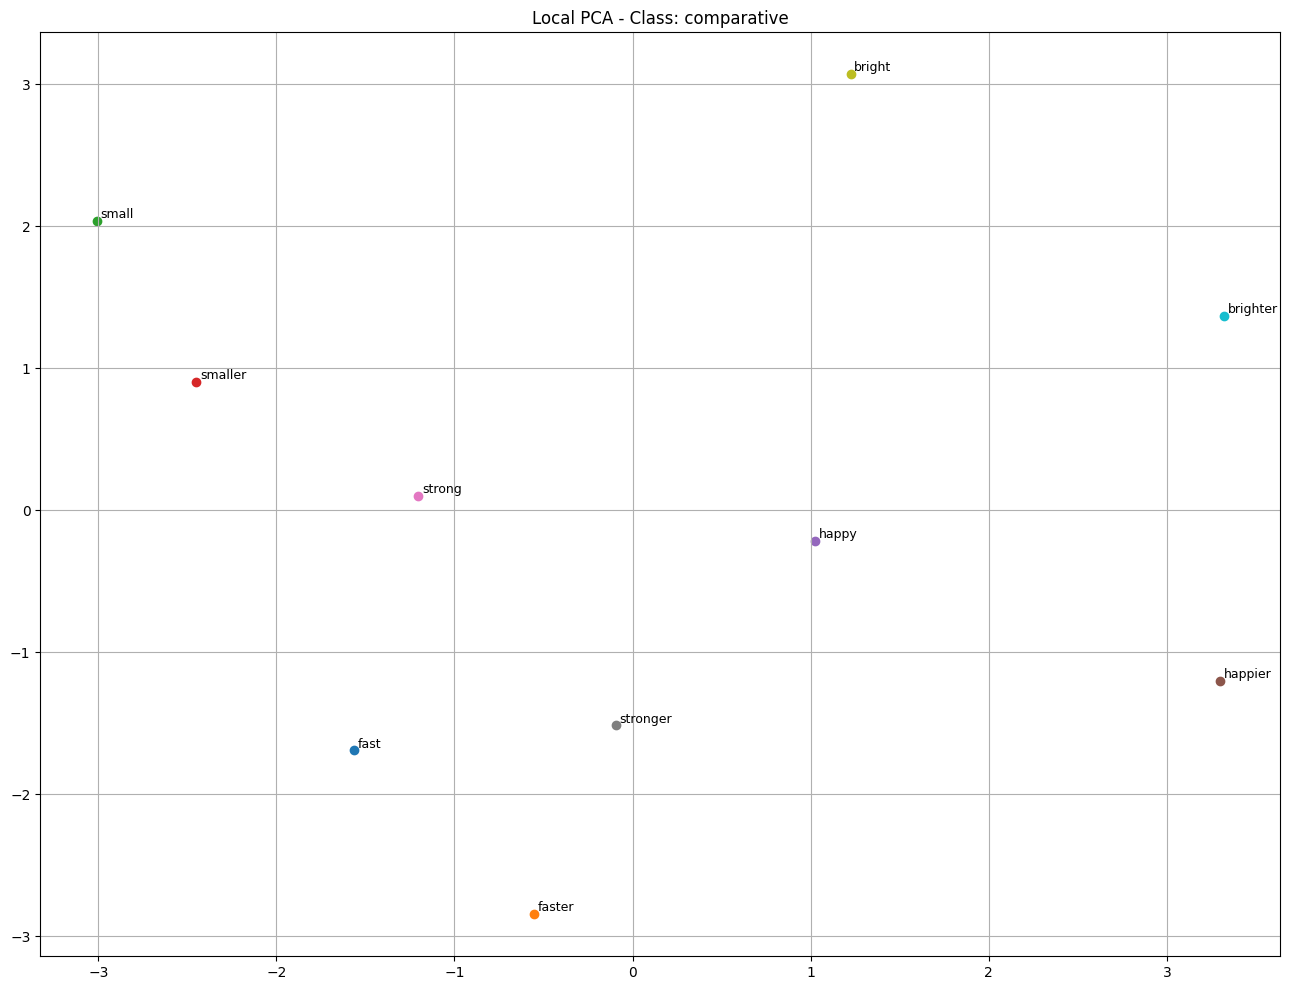

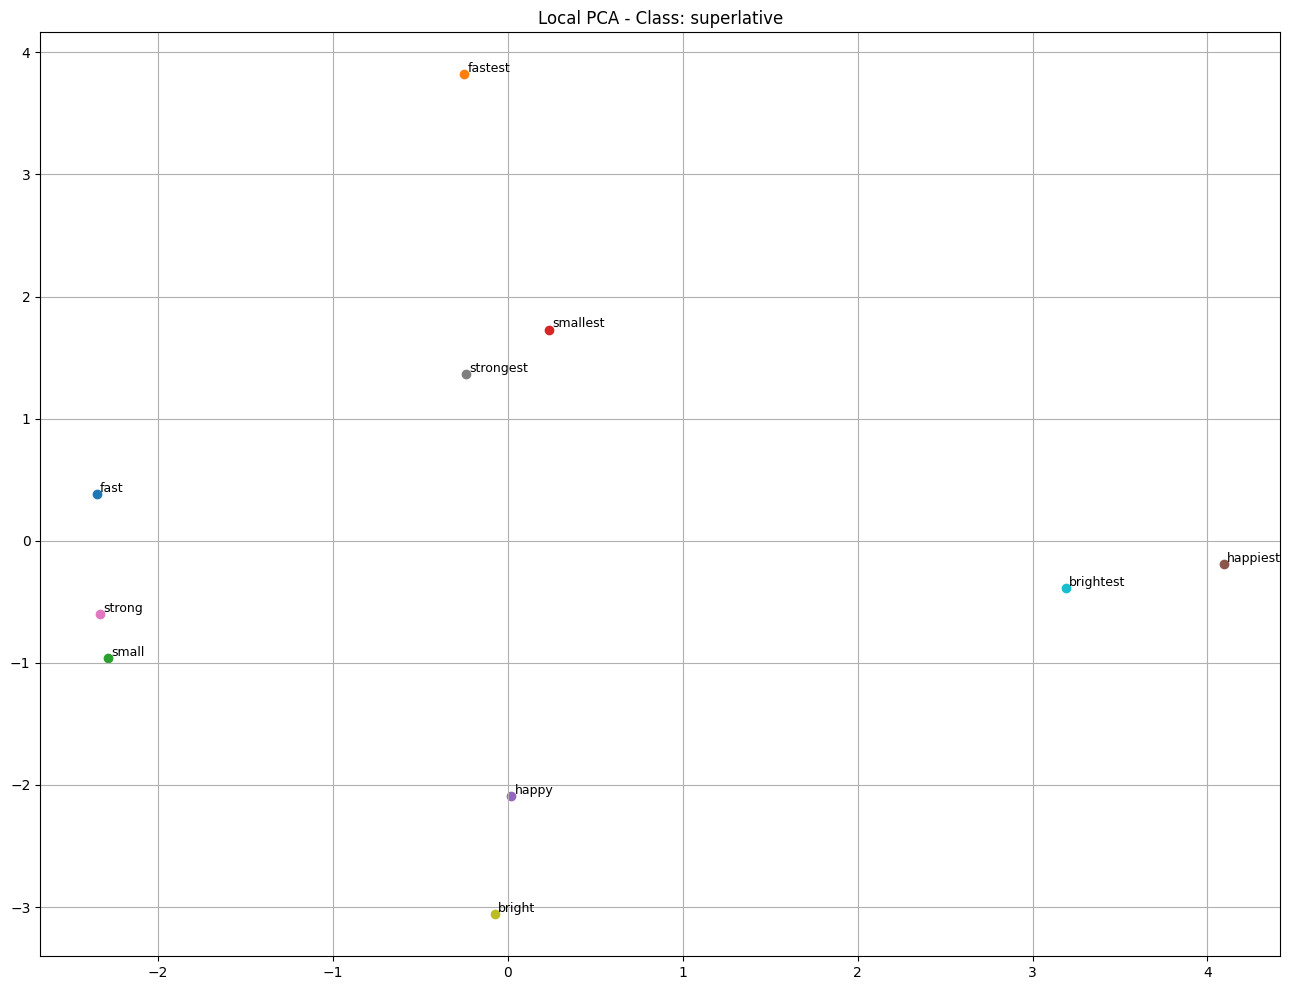

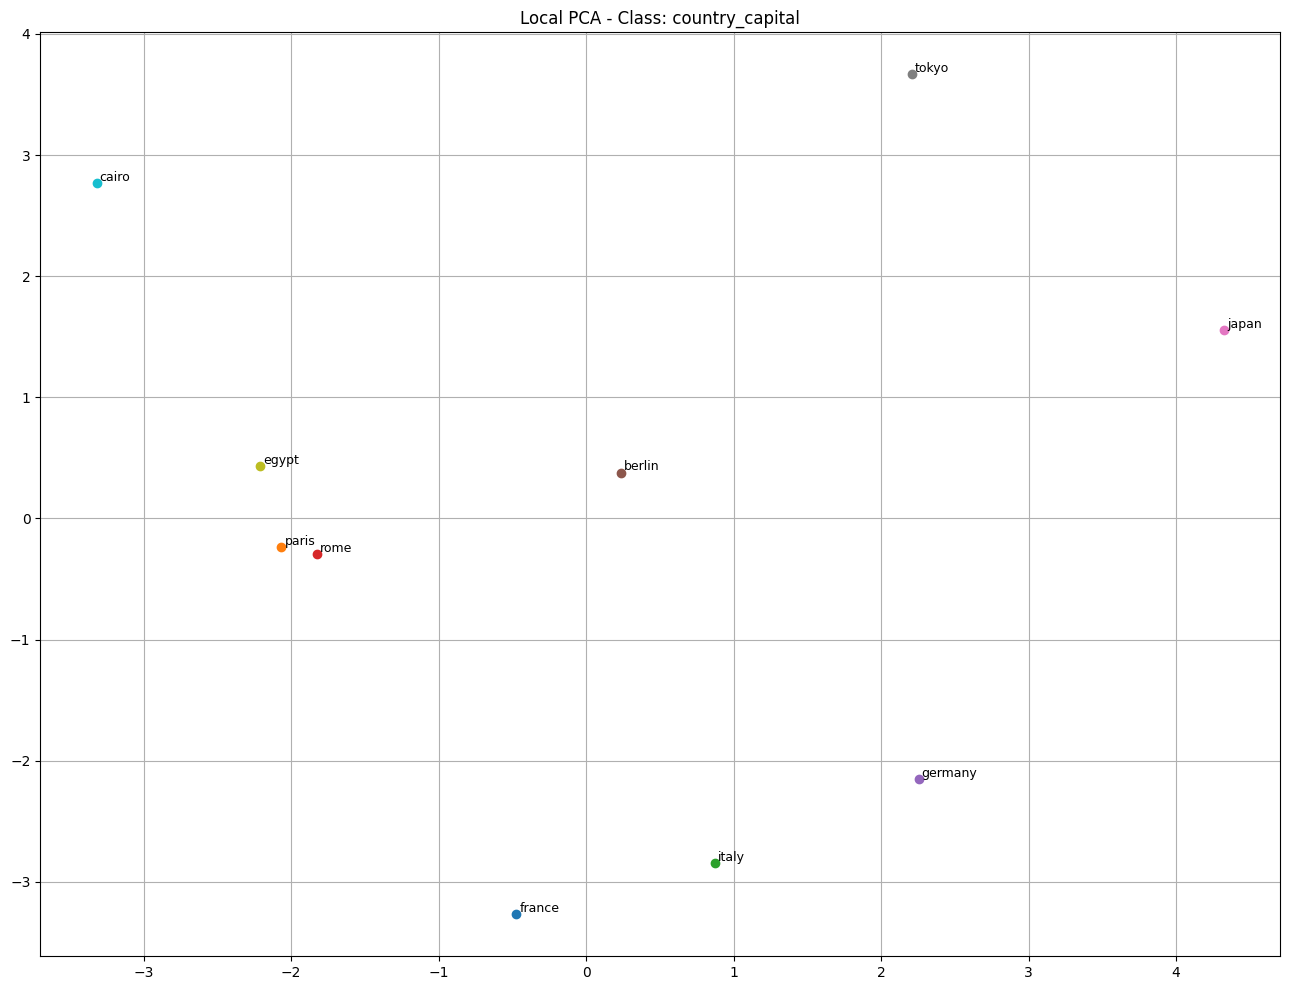

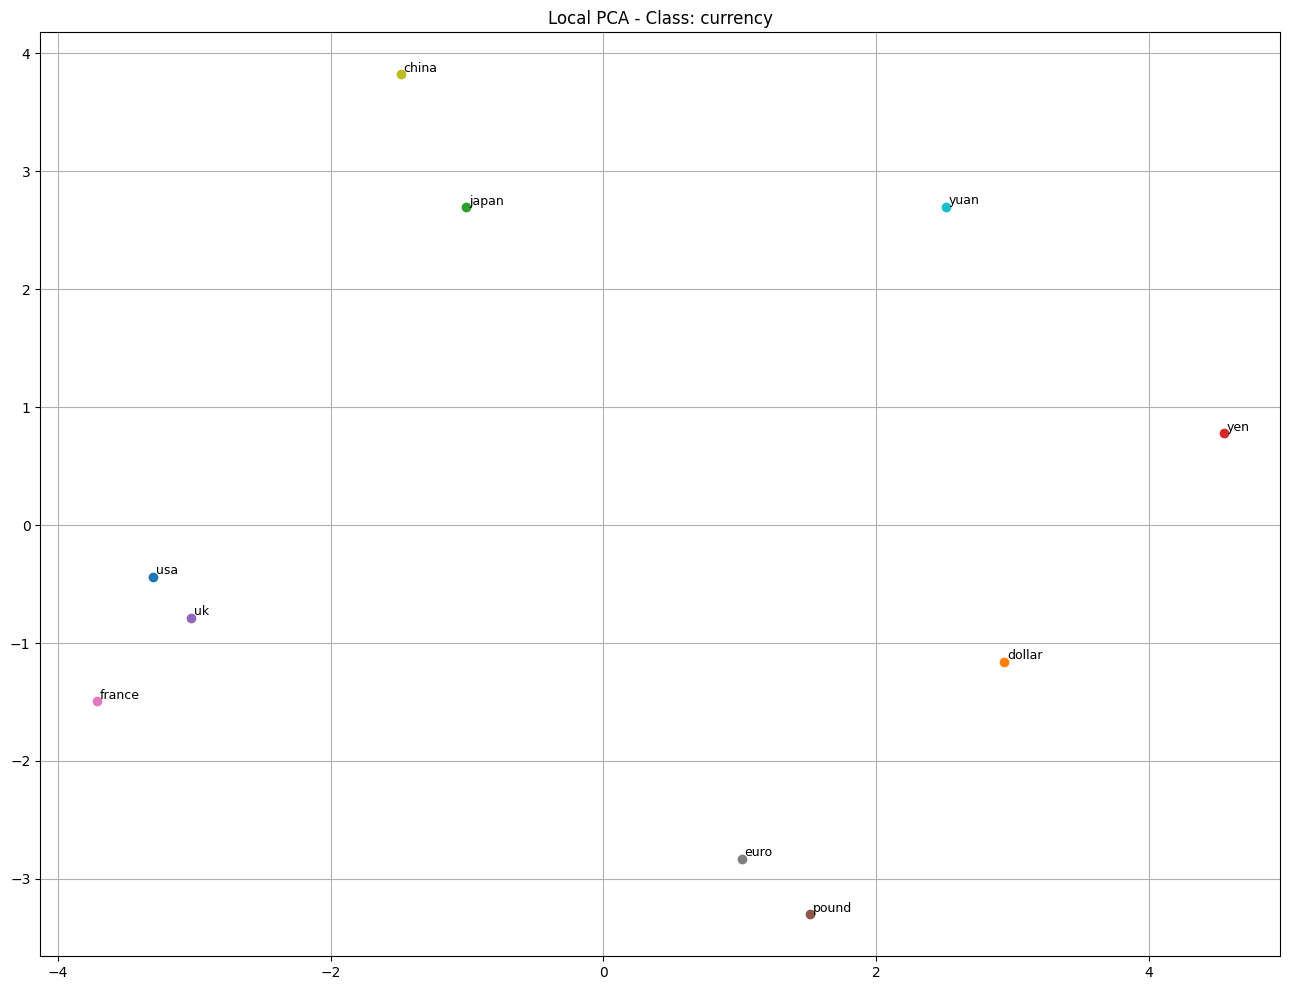

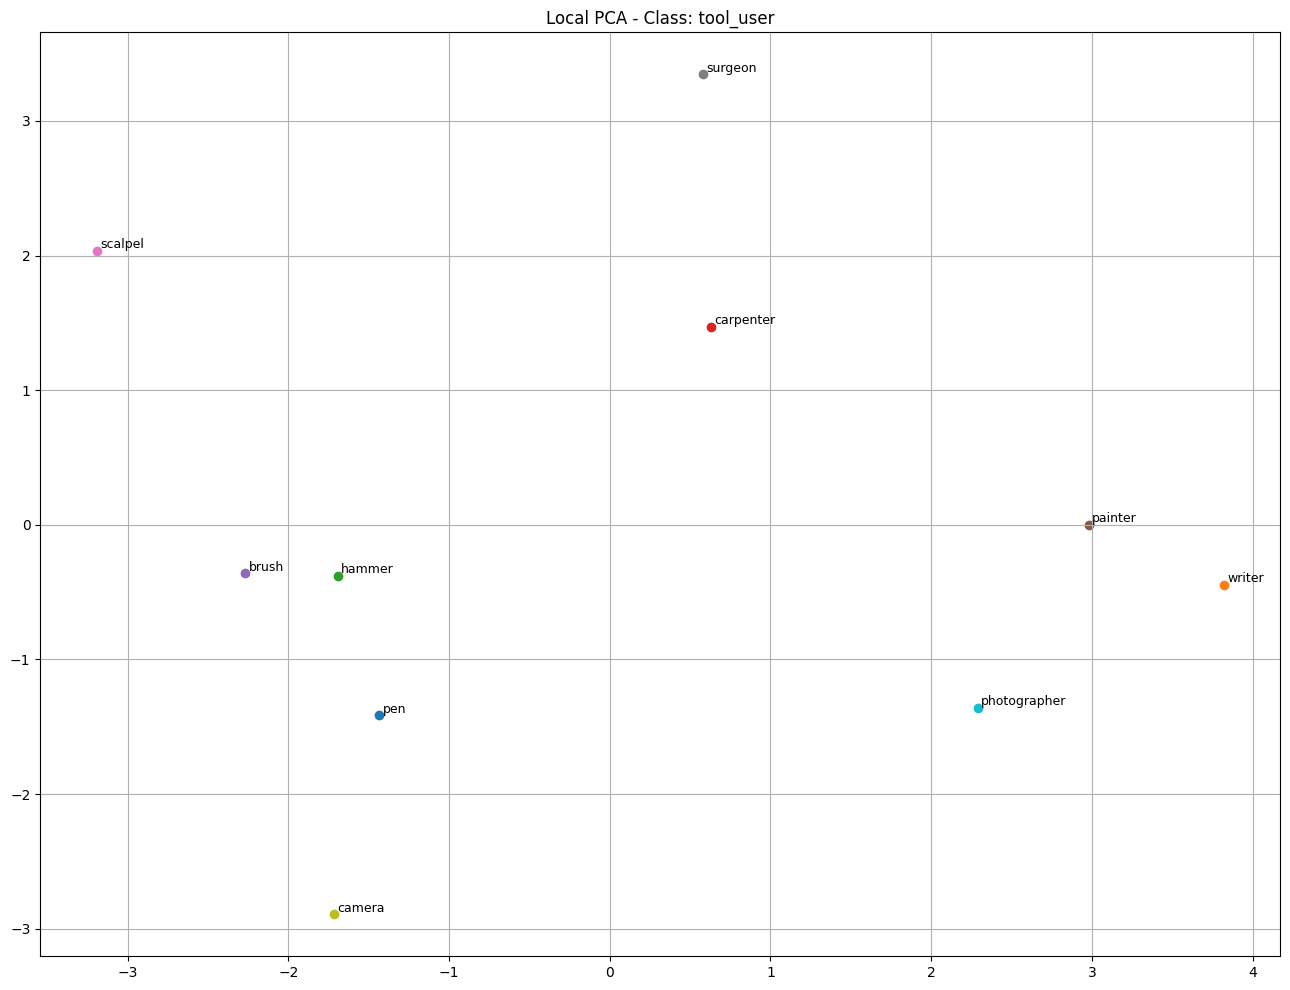

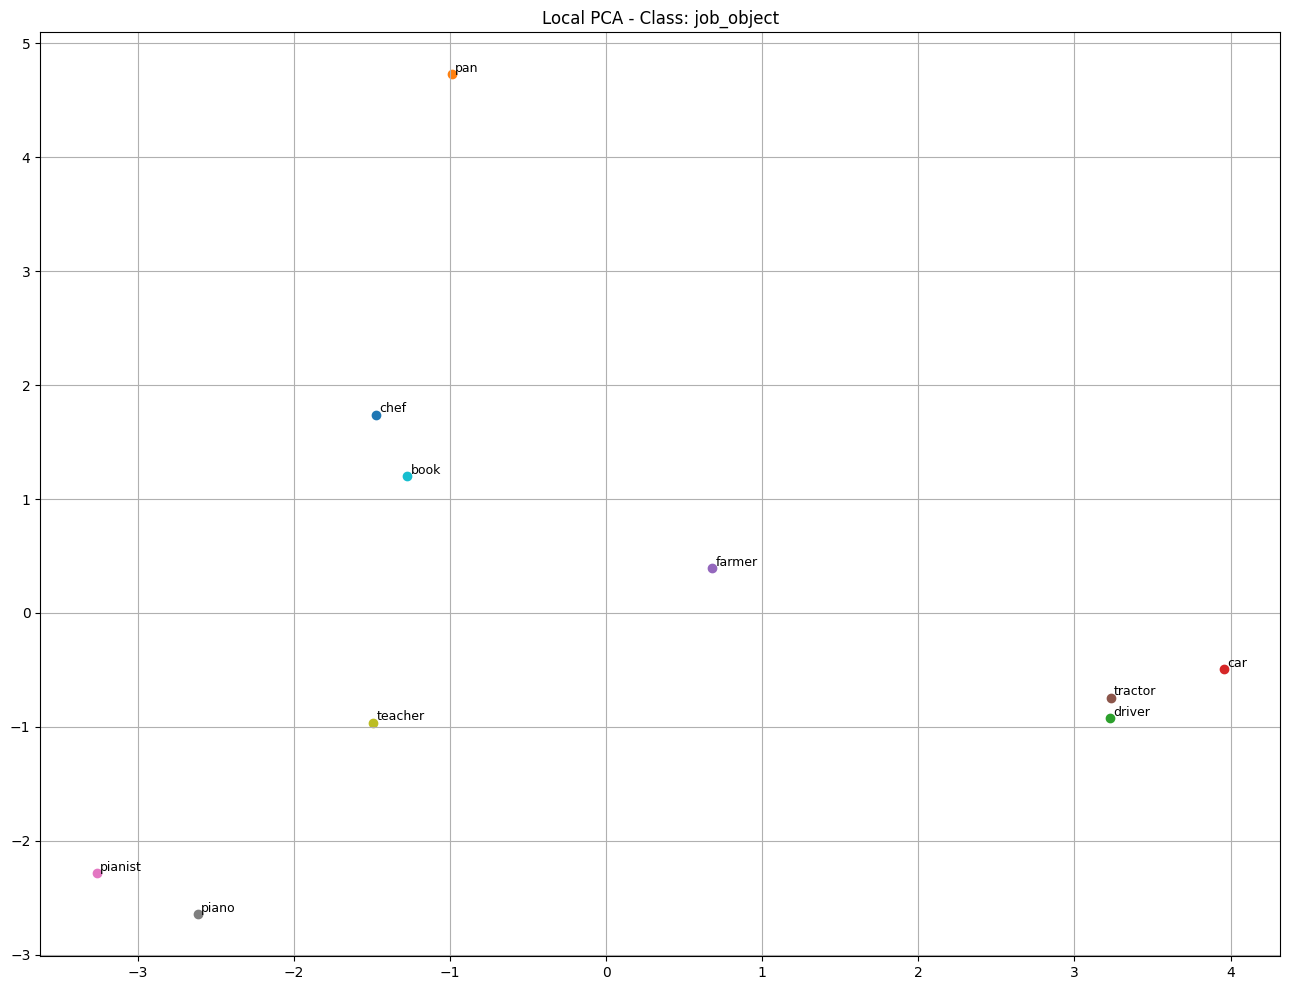

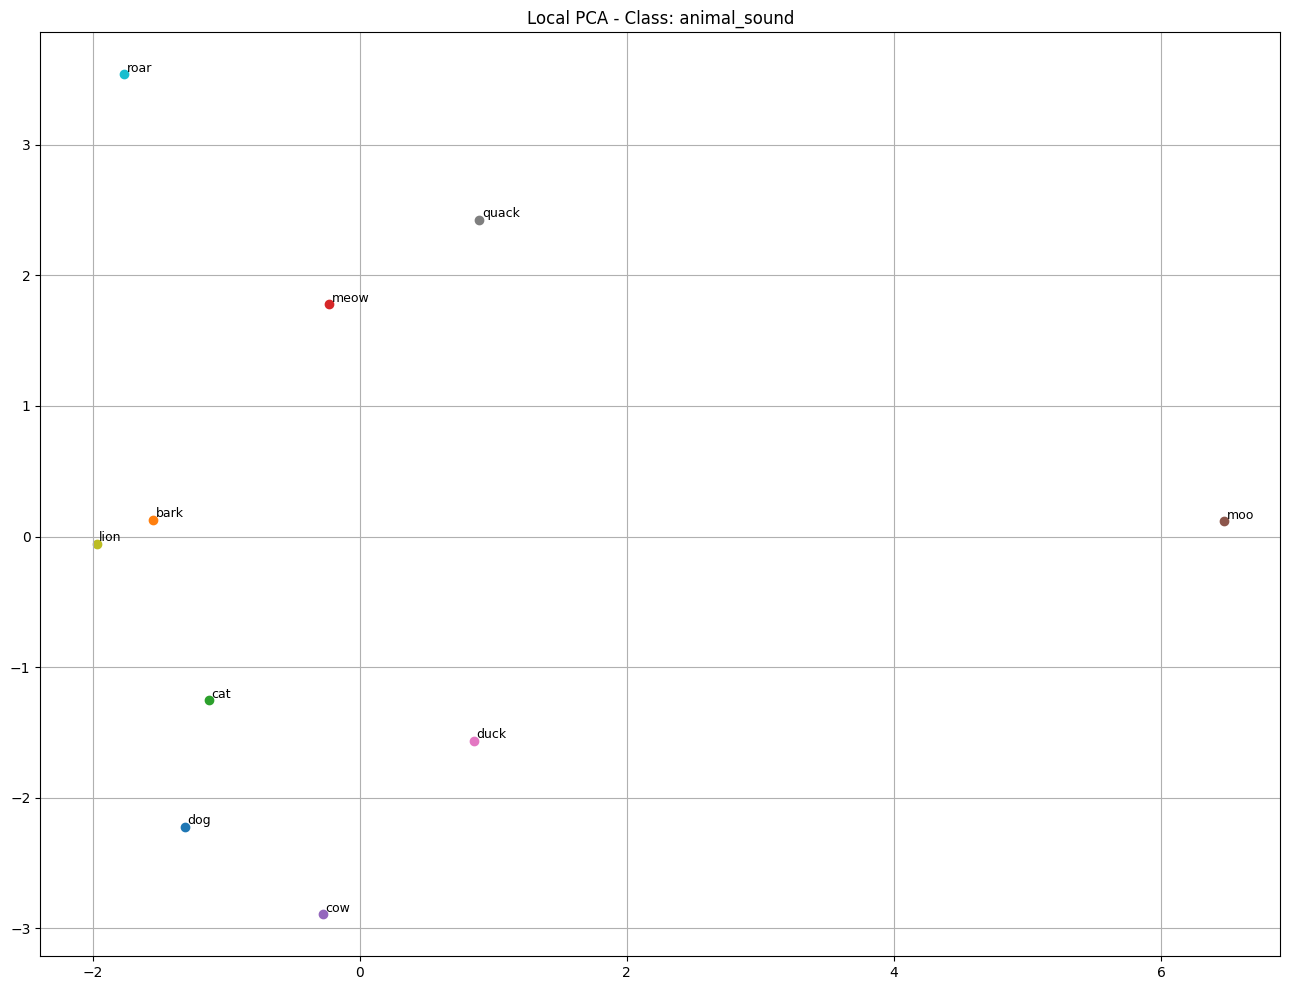

In [19]:
# Local PCA — each class separatelly, so PCA for 10 words in each class.
def plot_local_pca(class_name, pairs):
    class_words = [w for pair in pairs for w in pair if w in word_vectors]
    class_vectors = {word: word_vectors[word] for word in class_words}
    plot_words_2d(class_words, class_vectors, f"Local PCA - Class: {class_name}")

for class_name, pairs in semantic_classes.items():
    plot_local_pca(class_name, pairs)


##**And now we will do some embeddings, meaning calculate expressions such as: embedding("king") - embedding("man") + embedding("woman") ~= "queen"**

In [20]:
from sklearn.metrics.pairwise import cosine_similarity


In [21]:
def find_closest_words(vec, vectors_dict, topn=5):
    all_words = list(vectors_dict.keys())
    all_vecs = np.array([vectors_dict[w] for w in all_words])

    sims = cosine_similarity([vec], all_vecs)[0]
    sorted_indices = np.argsort(sims)[::-1]

    results = []
    for idx in sorted_indices[:topn]:
        results.append((all_words[idx], sims[idx]))
    return results


In [22]:
#Calculations for every class:
for class_name, pairs in semantic_classes.items():
    base_pair = pairs[0]  # (A, B)
    alt_pair = pairs[1]   # (C, D), weźmiemy C

    A, B = base_pair
    C, _ = alt_pair

    if A in word_vectors and B in word_vectors and C in word_vectors:
        result_vec = word_vectors[B] - word_vectors[A] + word_vectors[C]
        top_matches = find_closest_words(result_vec, word_vectors)

        print(f"\n=== Class: {class_name} ===")
        print(f"Operation: {B} - {A} + {C}")
        for word, score in top_matches:
            print(f"{word:<15} similarity: {score:.4f}")
    else:
        print(f"\nSkipping class '{class_name}' due to missing word(s)")



=== Class: gender ===
Operation: queen - king + man
woman           similarity: 0.8040
man             similarity: 0.7791
girl            similarity: 0.7349
boy             similarity: 0.6447
wife            similarity: 0.6073

=== Class: past_tense ===
Operation: ran - run + go
go              similarity: 0.7532
went            similarity: 0.7360
ran             similarity: 0.6971
happy           similarity: 0.5492
write           similarity: 0.5175

=== Class: plural ===
Operation: dogs - dog + car
cars            similarity: 0.8827
car             similarity: 0.8765
driver          similarity: 0.6695
tractor         similarity: 0.5405
went            similarity: 0.4981

=== Class: comparative ===
Operation: faster - fast + small
smaller         similarity: 0.8129
small           similarity: 0.7961
faster          similarity: 0.6221
smallest        similarity: 0.5807
cars            similarity: 0.4932

=== Class: superlative ===
Operation: fastest - fast + small
smallest        simi

##**Conclusion for second part of discussion (for PCA plots, we will make another 10 plots)**

In [24]:
# Globalne embeddingi po PCA były zapisane w reduced_embeddings
# Potrzebujemy słownika: słowo -> współrzędne PCA (globalne)
global_pca_dict = {word: reduced_embeddings[i] for i, word in enumerate(words)}

# Rysujemy overlay wykresy dla każdej klasy
for class_name, pairs in semantic_classes.items():
    words_in_class = [word for pair in pairs for word in pair]

    # Pobieramy globalne współrzędne PCA
    global_coords = np.array([global_pca_dict[word] for word in words_in_class])

    # Obliczamy lokalne PCA tylko dla słów z tej klasy
    local_vectors = np.array([model[word] for word in words_in_class])
    pca_local = PCA(n_components=2)
    local_coords = pca_local.fit_transform(local_vectors)

    # Rysowanie wykresu
    plt.figure(figsize=(8, 6))
    for i, word in enumerate(words_in_class):
        # Globalne: niebieskie kółka
        plt.scatter(global_coords[i, 0], global_coords[i, 1], color='blue', marker='o', label='Global PCA' if i == 0 else "")
        plt.text(global_coords[i, 0]+0.01, global_coords[i, 1]+0.01, word, fontsize=9, color='blue')

        # Lokalne: czerwone iksy
        plt.scatter(local_coords[i, 0], local_coords[i, 1], color='red', marker='x', label='Local PCA' if i == 0 else "")
        plt.text(local_coords[i, 0]+0.01, local_coords[i, 1]+0.01, word, fontsize=9, color='red')

    plt.title(f"PCA Global vs Local — {class_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


NameError: name 'reduced_embeddings' is not defined